In [48]:
import pandas as pd 
import numpy as np
from pathlib import Path
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import math

In [49]:
path = Path("../in-sample")
df_list = []
for file in path.glob("*.csv"):
    df_list.append(pd.read_csv(file))

total = pd.concat(df_list)
#total

<Axes: xlabel='spread-price', ylabel='volatility'>

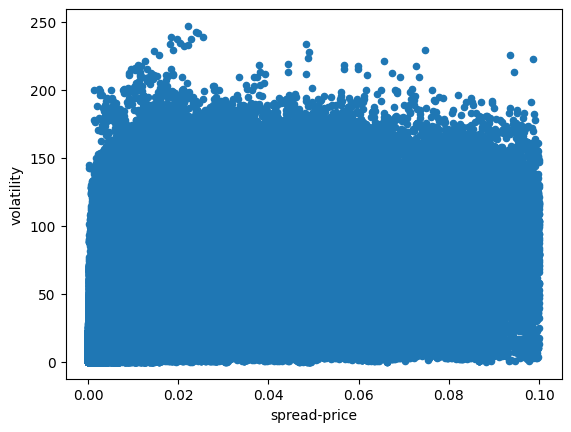

In [50]:
#GENERAL STUFF
total["inv_price"] = 1 / total["price"]
total["inv_avg_market_size"] = 1/ total["avg_market_size"]
total["inv_spx_beta"] = 1 / total["spx_beta"]
total["spread-price"] = total["med_spread_1"] / total["price"]
total["liquidity"] = total["price"] * total["volume"]
total["turnover"] = total["price"] * total["volume"]/total["market_cap"]
total["volatility"] = total["volatility"]

total["sqrt_liquidity"] = total["liquidity"].apply(lambda x : math.pow(x,0.5))

#get inv_sqrt_liq
#total = total[total["sqrt_liquidity"] > 1]
#total["inv_sqrt_liq"] = 1 / total["sqrt_liquidity"]

total[(total["spread-price"]<0.1)].plot.scatter("spread-price","volatility")

In [51]:
#different primary routes
# things = {}
# for i in total["primary_route"]:
#     if i in things.keys(): 
#         things[i] += 1
#     else: 
#         things[i] = 1 
# things
# total

In [52]:
#total.groupby('industry_group').trade_date.count().sort_values(ascending=False)

In [53]:
#Different Industries
#things = {}
#for i in total["industry_group"]:
#    if i in things.keys(): 
#        things[i] += 1
#    else: 
#        things[i] = 1 
#things

In [54]:
#Removal of Nan
temp = total
total = total.dropna(subset=total.columns.difference(["industry_group"]))

In [62]:
#Create the model and test it 

temp = total
print(len(total))


x_col = ["volatility","liquidity"]
y_col = "spread-price"

#"liquidity","spx_beta","avg_market_size"

split1 = int(0.35 * len(temp))
split2 = int(0.7 * len(temp))
df_train, df_middle , df_test = temp[:split1], temp[split1:split2] , temp[split2:]

#Outlier Removal Here 
df_train = df_train[((df_train["spread-price"]<0.1)) & (df_train["primary_route"] == "NASDAQ")]


weights = df_train["price"]*df_train["volume"]
weights = df_train["volume"]
weights = weights * df_train["price"]
weights = df_train["sqrt_liquidity"]
weights = weights.reset_index(drop=True)
for i in range(len(weights)):
    weights[i] = weights[i]


#print(f"Training from {df_train.index.date[0]} until {df_train.index.date[-1]}")

x_train = df_train[x_col]
x_middle = df_middle[x_col]
y_train = df_train[y_col]
y_middle = df_middle[y_col]
x_test = df_test[x_col]
y_test = df_test[y_col]

##TO CHANGE THE loss function. HUBER :   
model = make_pipeline(StandardScaler(),SGDRegressor(loss = "huber", max_iter=100, tol=1e-1))
model.fit(x_train, y_train)

print("huber R^2 values:")
print(model.score(x_train,y_train))
print(model.score(x_middle,y_middle))
print(model.score(x_test,y_test))

model = make_pipeline(StandardScaler(),SGDRegressor(loss = "epsilon_insensitive", max_iter=100, tol=1e-1))
model.fit(x_train, y_train)

print("\nepsilon insensitive R^2 values:")
print(model.score(x_train,y_train))
print(model.score(x_middle,y_middle))
print(model.score(x_test,y_test))

1044716
huber R^2 values:
0.2905141716369768
-1.7241138851042948e-05
-3.897453211720858e-06

epsilon insensitive R^2 values:
-0.9102835316637399
-1.7928134357969583e-05
-3.900792515887375e-06


In [56]:
path = Path("../out-of-sample")
df_list = []
for file in path.glob("*.csv"):
    df_list.append(pd.read_csv(file))

out_sample = pd.concat(df_list)
out_sample

,index,symbol,trade_date,volume,price,volatility,spx_beta,market_cap,avg_market_size,primary_route,industry_group
0,0,AAAU US,2019-04-23,12704.0,12.735,6.1312,-0.014130,105.70,13036.371448,ARCA,NaN
1,1,AABA US,2019-04-23,5731005.0,75.370,17.4336,1.090719,45637.16,1017.565371,NASDAQ,NaN
2,2,AAC US,2019-04-23,103889.0,1.460,99.3792,1.608872,36.03,684.883388,NYSE,Healthcare-Services
3,3,AADR US,2019-04-23,5688.0,45.340,10.2080,0.147911,105.42,454.320284,ARCA,NaN
4,4,AAL US,2019-04-23,5230768.0,33.480,24.7872,1.006304,15034.38,887.266252,NASDAQ,Airlines
...,...,...,...,...,...,...,...,...,...,...,...
7591,7591,ZUO US,2019-02-15,1118206.0,22.510,51.1488,1.646327,2442.39,441.203734,NYSE,Software
7592,7592,Z US,2019-02-15,1885374.0,35.970,44.0960,1.355136,7301.62,320.382875,NASDAQ,Internet
7593,7593,ZYME US,2019-02-15,45039.5,15.510,52.0192,0.870908,495.97,242.680455,NYSE,Biotechnology
7594,7594,ZYNE US,2019-02-15,1151944.5,5.330,97.3440,1.848774,93.95,834.423851,NASDAQ,Pharmaceuticals


In [57]:
x = out_sample[x_col]
y = out_sample[y_col]

print(model.score(x,y))

KeyError: "['liquidity'] not in index"